# Reading Single Day of Data

Getting things set up

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib as mpl
from bokeh import palettes
from bokeh.charts import Bar
import math
from IPython.display import Image

In [2]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [3]:
%matplotlib inline

The below file is a sample day of data stored as an HDF5 file. It can be read as a DataFrame.

In [55]:
# file = r'D:\ADSB\working\h5\2016-12-02.h5'
# file = r'/Users/lukestarnes/ADSB/h5/2016-12-24.h5'
file = r'/Users/lukestarnes/ADSB/h5/2017-01-01.h5'

In [66]:
store = pd.HDFStore(file)

In [69]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: /Users/lukestarnes/ADSB/h5/2016-12-24.h5
/data            frame_table  (typ->appendable,nrows->5002397,ncols->60,indexers->[index],dc->[Alt,Cou,FSeen,PosTime,From,Icao,Id,Lat,Long,Mil,To,Type,Op,OpIcao,Help,Stops])

How many rows are in the file?

In [70]:
store.get_storer('data').nrows

5002397

In [71]:
day_of_data_df = store.select('data',start=0, stop=200000)
# day_of_data_df = store.select('data','Lat >= 35.573914 & Lat<=49.9955855709 & Long>=-125.4693837406 & Long<=-65.3309038418')#.drop_duplicates()

And how many unique aircraft reports?

In [72]:
len(day_of_data_df['Icao'].unique())

9454

And how many of the rows contain lat/long/alt?

In [73]:
day_of_data_df['Lat'].count(), day_of_data_df['Long'].count(), day_of_data_df['Alt'].count()

(175480, 175480, 198449)

What about Manufacturer or Aircraft Type?

In [74]:
day_of_data_df['Man'].count(),day_of_data_df['Type'].count()

(191307, 191323)

Below is a Pivot Table showing the number of unique aircraft and the number of unique aircraft manufacturers by Airaft Country (where it is registered).

In [75]:
pd.pivot_table(day_of_data_df,values=['Id','Man'],index='Cou', 
               aggfunc=lambda x: len(x.unique())).sort_values(by='Id',ascending=False)[:30]

,Id,Man
Cou,,
United States,5020,79
China,626,6
Canada,509,25
Australia,402,34
United Kingdom,186,9
Unknown or unassigned country,186,2
Brazil,179,7
Spain,177,9
Italy,172,6


## Airfraft Manufacturers 

In [76]:
aircraft_df = day_of_data_df[['Id','Cou','Year','Man','Type']].dropna(how='all')
aircraft_df = aircraft_df.drop_duplicates(subset='Id')

Here are the top aircraft manufacturers.

In [77]:
mfr = aircraft_df.groupby('Man').count()['Id'].sort_values(ascending=False)[:10]
aircraft_df_by_mfr = aircraft_df[aircraft_df['Man'].isin(list(mfr.index))].groupby(['Man']).count()
aircraft_df_by_mfr = aircraft_df_by_mfr.sort_values(by='Id', ascending=False)
print('Total number of manufactuers: %i' % len(aircraft_df.groupby('Man').count()['Id']))
aircraft_df_by_mfr['Id']

Total number of manufactuers: 109


Man
Boeing                          3087
Airbus                          2215
Bombardier                       837
Embraer                          634
Cessna                           351
McDonnell Douglas                230
Beech                             89
Avions de Transport Regional      85
Gulfstream Aerospace              79
Eurocopter                        72
Name: Id, dtype: int64

In [78]:
p = Bar(aircraft_df_by_mfr, label='index', values='Id', 
        xlabel='Aircraft Manufacturer', ylabel='Number of Aircraft',
        title="Major Aircraft Manufactures", width=800, legend=None, 
        tools='pan,wheel_zoom,box_zoom,reset',color='wheat')
p.title.text_font_size = "12pt"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"
p.xaxis.major_label_text_font = "10pt"
p.yaxis.major_label_text_font = "10pt"
show(p)

## Airports by Country

Grabed a csv that provides airports (by ICAO name) to county.

In [79]:
airport_codes = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', 
                            index_col=0,header=None)
airport_codes.columns = ['Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 
                                     'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source']
airport_codes.set_index('ICAO',drop=True,inplace=True)
airport_codes.head(3)

,Name,City,Country,IATA,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
ICAO,,,,,,,,,,,,
AYGA,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMD,Madang Airport,Madang,Papua New Guinea,MAG,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMH,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.82679,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports


Construct a dataframe listing the number (and percentage) of each arrival/departure.

In [80]:
def country_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'Country'].item()
    else:
        return ''

def city_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'City'].item()
    else:
        return ''

In [81]:
us_airports = airport_codes[airport_codes['Country'] == 'United States'].index.values
usa_from = day_of_data_df[day_of_data_df['From'].isin(us_airports)]
usa_to = day_of_data_df[day_of_data_df['To'].isin(us_airports)]
us_airports_df = pd.concat((usa_from, usa_to)).drop_duplicates()

In [103]:
airports = pd.DataFrame()
airports['From'] = day_of_data_df.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['To'] = day_of_data_df.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['From'] = airports['From'].fillna(0).map(np.int64)
airports['To'] = airports['To'].fillna(0).map(np.int64)
airports['From (%)'] = airports['From']/airports['From'].sum() * 100
airports['To (%)'] = airports['To']/airports['To'].sum() * 100
airports['From'] = airports['From'].fillna(0)
airports.index.name = 'Airport'
airports.sort_values(by='To',ascending=False).head(20)

,From,To,From (%),To (%)
Airport,,,,
KLAX,148,133,4.141018,3.919835
KJFK,101,94,2.825965,2.770410
EGLL,40,90,1.119194,2.652520
KMCO,55,76,1.538892,2.239906
KBOS,49,73,1.371013,2.151488
KDFW,65,68,1.818691,2.004126
KSFO,89,66,2.490207,1.945181
KORD,70,62,1.958590,1.827291
KMIA,31,55,0.867375,1.620984


And here it is grouped by country.

In [104]:
airport_country = airports.groupby(airports['From']) # 'Country' does not exist in airports obj
if airport_country:
    airport_country.sum().sort_values(by='To',ascending=False).head(20)

Below is a plot of the top 30 international departure airports.

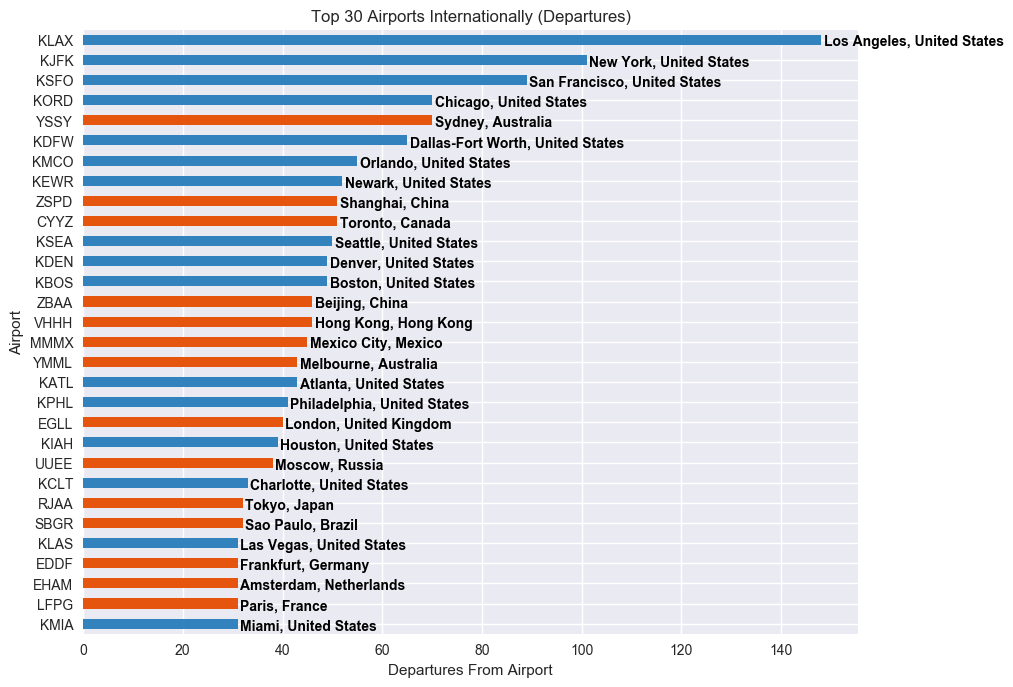

In [105]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = airports.sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From'].plot(kind='barh',color=color, title='Top 30 Airports Internationally (Departures)')
ax.set_xlabel('Departures From Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .50,y + height, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

Below is a plot of the top 30 international arrival airports.

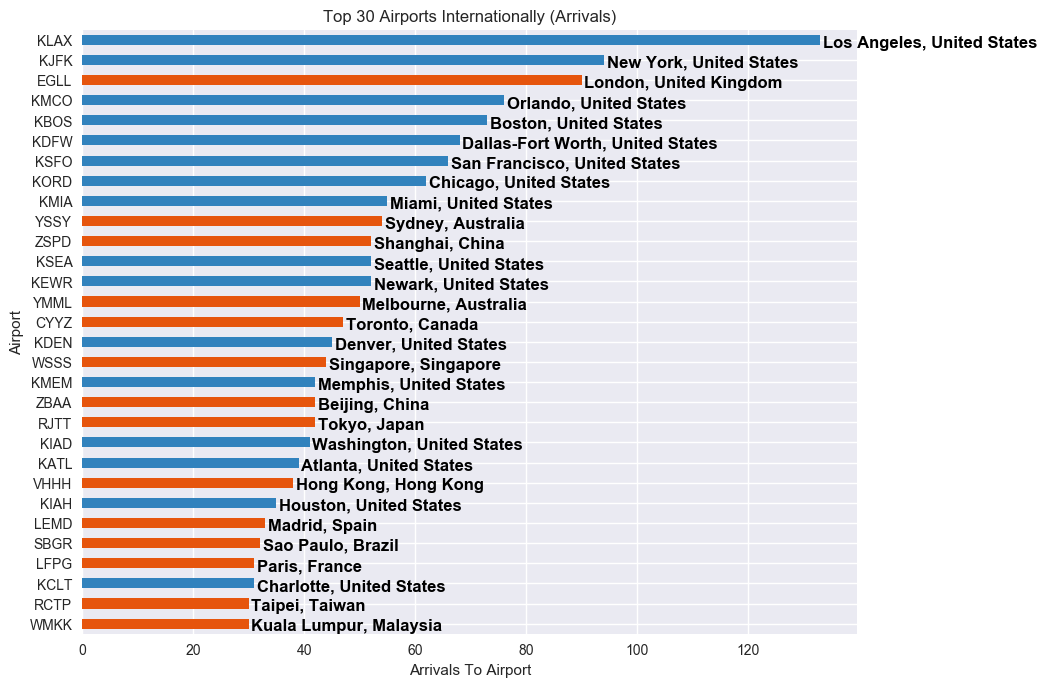

In [107]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = airports.sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To'].plot(kind='barh', color=color, title='Top 30 Airports Internationally (Arrivals)')
ax.set_xlabel('Arrivals To Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .5,y + height, label, color='black',fontsize=12, ha='left', va='top', weight='heavy')

# Here is similar data for flights that start or stop in the US

In [108]:
usa_airports = pd.DataFrame()
usa_airports['From'] = day_of_data_df.groupby(["From"]).Id.nunique()
usa_airports['To'] = day_of_data_df.groupby(["To"]).Id.nunique()
usa_airports['From'] = usa_airports['From'].fillna(0).map(np.int64)
usa_airports['To'] = usa_airports['To'].fillna(0).map(np.int64)
usa_airports['From (%)'] = usa_airports['From']/usa_airports['From'].sum() * 100
usa_airports['To (%)'] = usa_airports['To']/usa_airports['To'].sum() * 100
usa_airports['Country'] = [country_lu(code) for code in usa_airports.index.values]
usa_airports['Domestic'] = usa_airports.index.isin(us_airports)
usa_airports.index.name = 'Airport'
usa_airports.sort_values(by='To',ascending=False).head(5)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
KLAX,133,148,3.719239,4.479419,United States,True
KJFK,94,101,2.628635,3.056901,United States,True
KSFO,66,89,1.845638,2.693705,United States,True
KORD,62,70,1.733781,2.118644,United States,True
YSSY,54,70,1.510067,2.118644,Australia,False


In [109]:
usa_airports.groupby(usa_airports['Domestic']).sum()

,From,To,From (%),To (%)
Domestic,,,,
False,2074,1888,57.997763,57.142857
True,1502,1416,42.002237,42.857143


The top 30 airports where the destination is in the US.

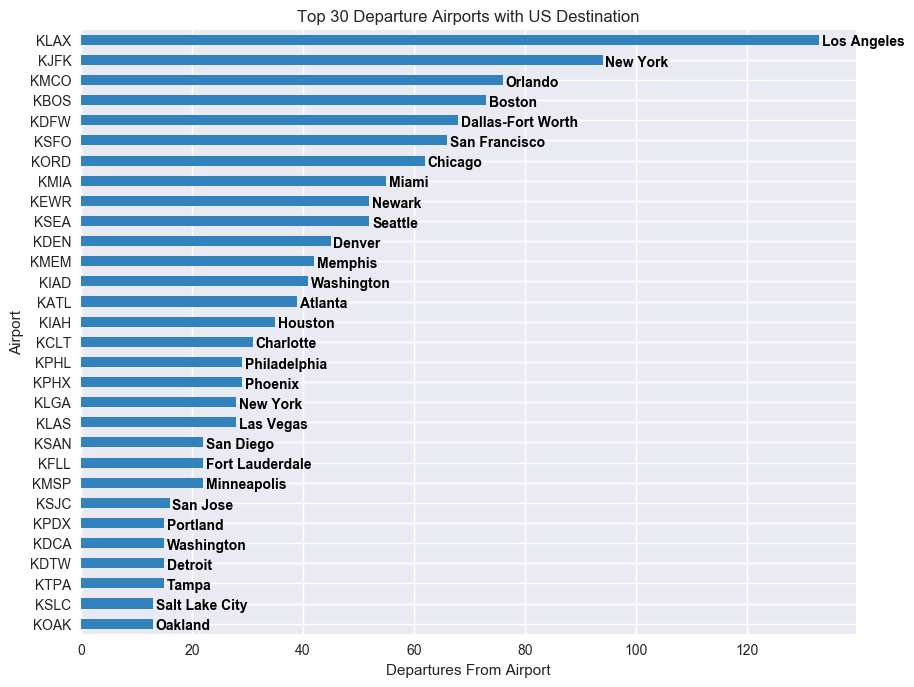

In [114]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = usa_airports[usa_airports.To.index.isin(us_airports)].sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),
                 palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From'].plot(kind='barh', color=color, title='Top 30 Departure Airports with US Destination')
ax.set_xlabel('Departures From Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .5,y + height, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

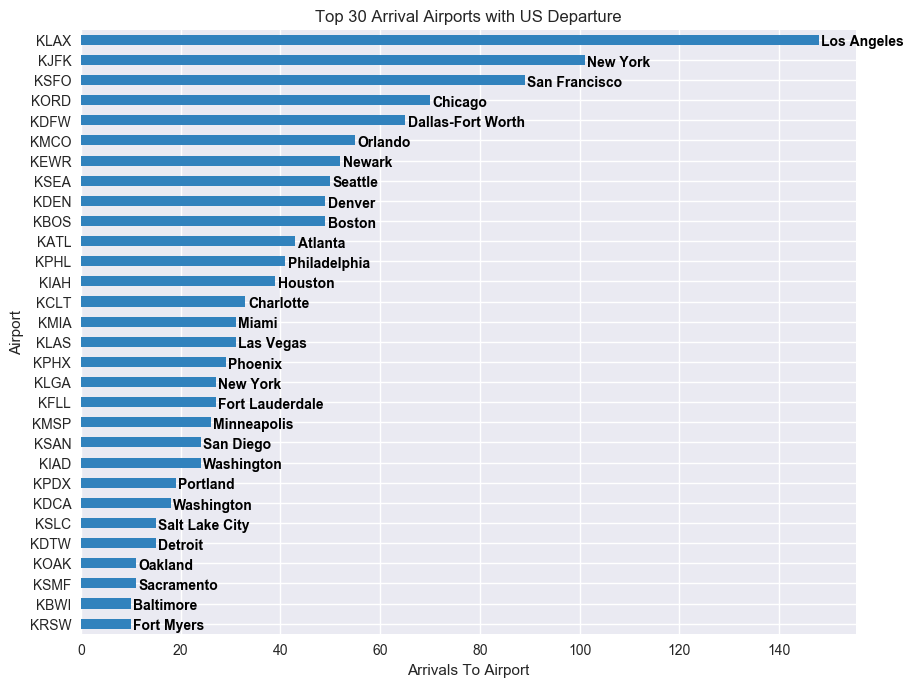

In [115]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = usa_airports[usa_airports.From.index.isin(us_airports)].sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports), palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To'].plot(kind='barh',  color=color, title='Top 30 Arrival Airports with US Departure')
ax.set_xlabel('Arrivals To Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .5,y + height, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

In [116]:
international = usa_airports[~usa_airports.From.index.isin(us_airports)]
international = international[~international.To.index.isin(us_airports)]
international.sort_values(by='From',ascending=False).head(10)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
EGLL,90,40,2.516779,1.210654,United Kingdom,False
YSSY,54,70,1.510067,2.118644,Australia,False
ZSPD,52,51,1.454139,1.543584,China,False
YMML,50,43,1.398210,1.301453,Australia,False
CYYZ,47,51,1.314318,1.543584,Canada,False
WSSS,44,28,1.230425,0.847458,Singapore,False
ZBAA,42,46,1.174497,1.392252,China,False
RJTT,42,30,1.174497,0.907990,Japan,False
VHHH,38,46,1.062640,1.392252,Hong Kong,False


In [117]:
international_country = international.groupby(international['Country'])
print('Main contries traveled to:\n',', '.join(list(international_country.sum().sort_values(by='To',
                                                                                 ascending=False).head(20).index)))
print('Main countries traveled from:\n', ', '.join(list(international_country.sum().sort_values(by='From',
                                                                                   ascending=False).head(20).index)))

Main contries traveled to:
 China, Australia, Canada, Japan, Brazil, United Kingdom, Mexico, Russia, Germany, Hong Kong, New Zealand, United Arab Emirates, France, Malaysia, Colombia, Netherlands, Indonesia, South Korea, Italy, Singapore
Main countries traveled from:
 China, Australia, United Kingdom, Canada, Brazil, Japan, Mexico, Spain, Germany, Russia, Malaysia, Singapore, United Arab Emirates, Italy, France, Hong Kong, New Zealand, Taiwan, Turkey, Indonesia


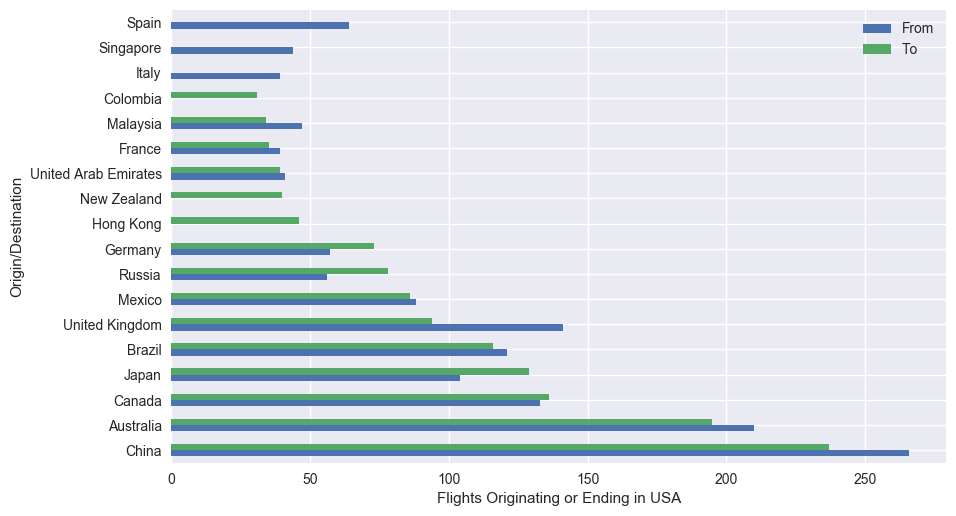

In [126]:
mpl.rcParams['figure.figsize'] = 10, 6
mpl.rcParams['figure.dpi'] = 100
from_ = international_country.sum().sort_values(by='From',ascending=False).head(15)['From']
to_ = international_country.sum().sort_values(by='To',ascending=False).head(15)['To']
ax = pd.concat([from_, to_], axis=1).sort_values(by='To',ascending=False).plot(kind='barh')
ax.set_xlabel('Flights Originating or Ending in USA')
ax.set_ylabel('Origin/Destination')

And Atlanta...

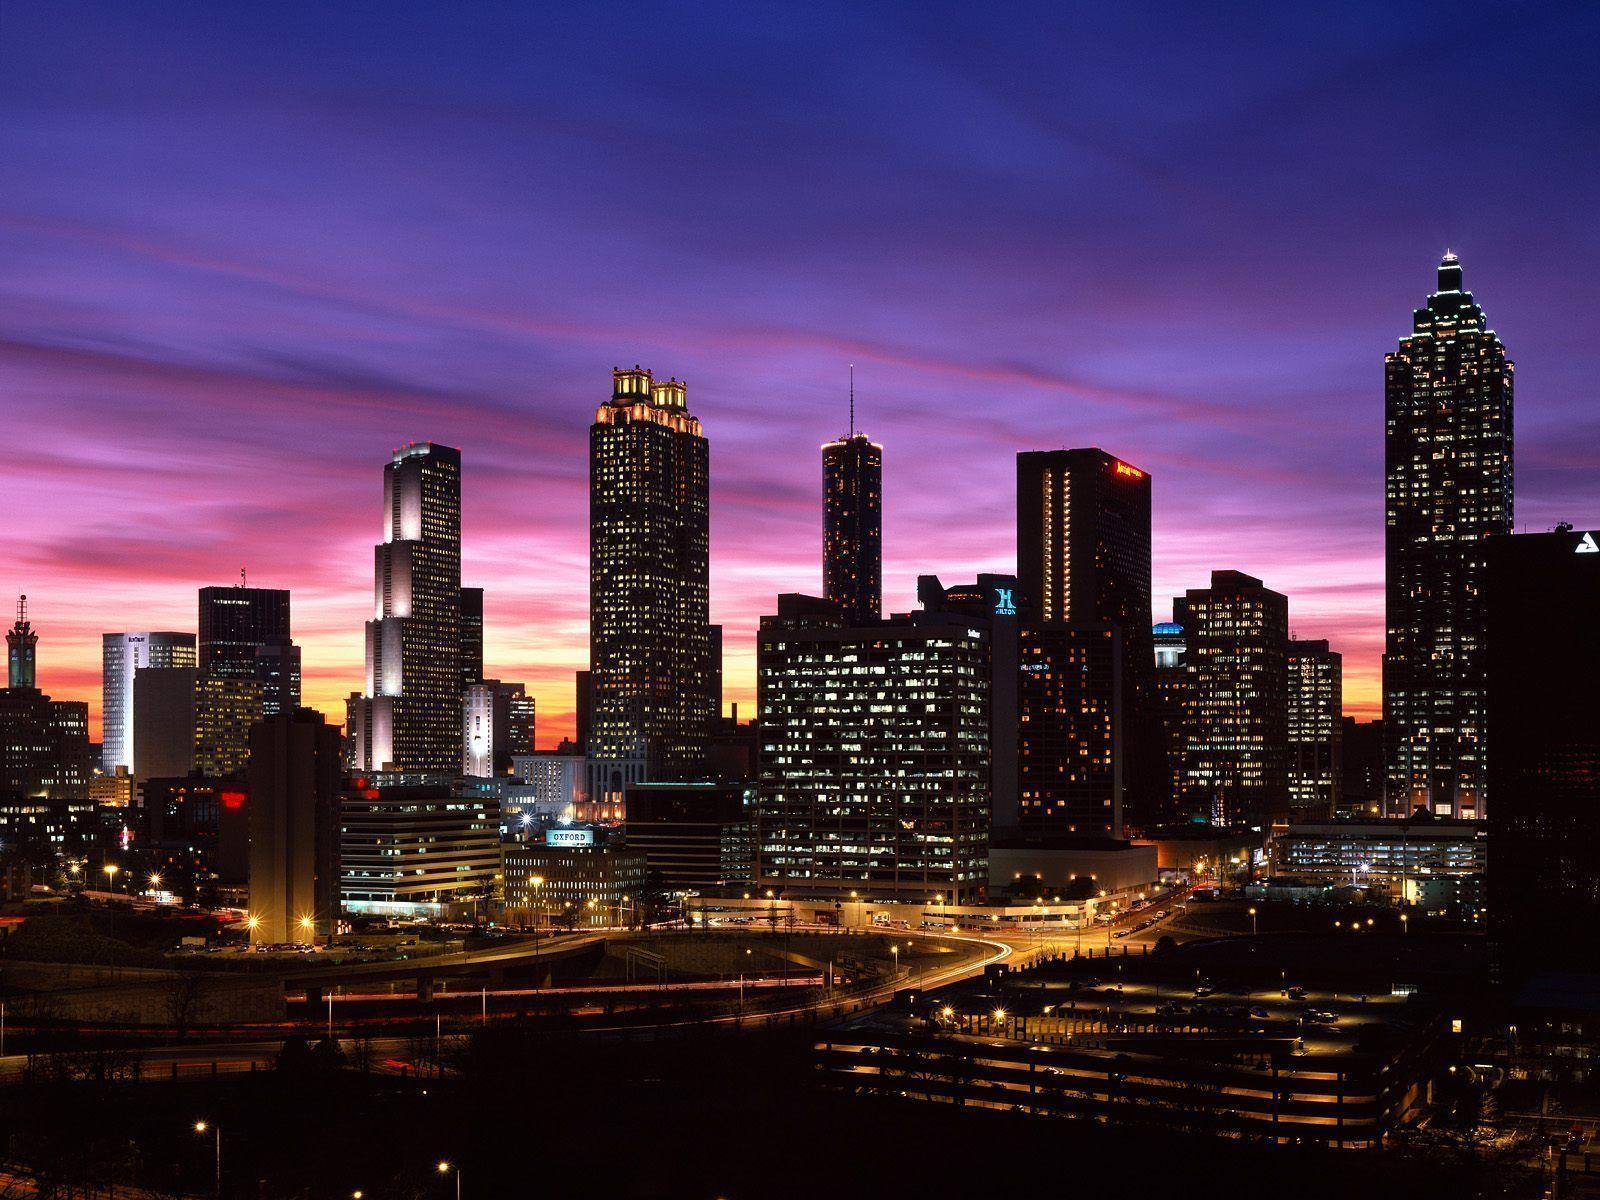

In [119]:
Image("http://wallpapercave.com/wp/E48LtWF.jpg")

In [138]:
atl[:3]

,From,To,From (%),To (%),Country
To,,,,,
KBOI,1,0,1.408451,0.000000,United States
LIRF,1,0,1.408451,0.000000,Italy
LFPG,1,1,1.408451,1.923077,France


In [147]:
# atl_ = store.select('data',where='From = "KATL" | To = "KATL"').drop_duplicates()
atl_ = day_of_data_df.query('From == "KATL" | To == "KATL"')
atl = pd.DataFrame()
atl['From'] = atl_.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=False)
atl['To'] = atl_.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=False)
atl['From'] = atl['From'].fillna(0).map(np.int64)
atl['To'] = atl['To'].fillna(0).map(np.int64)
atl['From (%)'] = atl['From']/atl['From'].sum() * 100
atl['To (%)'] = atl['To']/atl['To'].sum() * 100
atl['Country'] = [country_lu(code) for code in atl.index.values]
atl.drop('KATL', inplace=True)
atl['Both'] = atl['From'] + atl['To']
atl = atl.sort_values(by='Both',ascending=False).head(15)
atl

,From,To,From (%),To (%),Country,Both
To,,,,,,
KBOS,2,3,2.816901,5.769231,United States,5
KLAX,3,1,4.225352,1.923077,United States,4
KSFO,2,1,2.816901,1.923077,United States,3
KCLT,2,0,2.816901,0.000000,United States,2
KALB,1,1,1.408451,1.923077,United States,2
KDFW,1,1,1.408451,1.923077,United States,2
EGLL,1,1,1.408451,1.923077,United Kingdom,2
LFPG,1,1,1.408451,1.923077,France,2
KSLC,1,1,1.408451,1.923077,United States,2


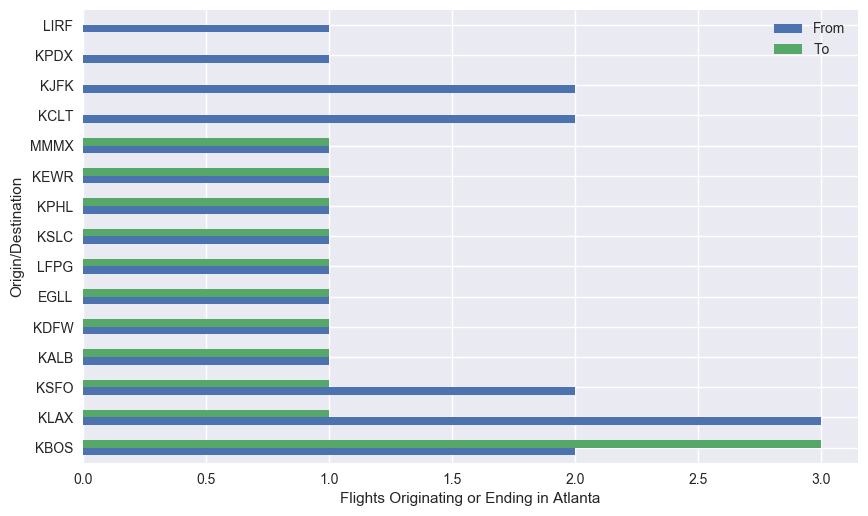

In [148]:
mpl.rcParams['figure.figsize'] = 10, 6
mpl.rcParams['figure.dpi'] = 100
from_ = atl['From']#atl.sort_values(by='From',ascending=False).head(15)['From']
to_ = atl['To']#atl.sort_values(by='To',ascending=False).head(15)['To']
ax = pd.concat([from_, to_], axis=1).sort_values(by='To',ascending=False).plot(kind='barh')
ax.set_xlabel('Flights Originating or Ending in Atlanta')
ax.set_ylabel('Origin/Destination')